Pipeline 1: Thu thập Dữ liệu và Tiền xử lý ban đầu

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc  # Thu gom rác bộ nhớ
gc.collect()  # Ép thu gom rác

/Users/naotod/Downloads/code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


0

In [2]:
import os
import pathlib
import pandas as pd  # Make sure you import pandas

print("Current working directory:", os.getcwd())
print(pathlib.Path("data/processed/cv/processed_results.json").resolve())

try:
   # Đọc dữ liệu CV từ tệp JSON
    df = pd.read_json('data/processed/cv/processed_results.json')
    
    print("Data loaded successfully")
    print("Number of documents:", len(df))
    
  # Khởi tạo trình phân tích cú pháp
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    
    tokenizer = Tokenizer(num_words=5000)
    
    # Phù hợp với tokenizer trên văn bản
    texts = df['text'].values  # Giả sử 'text' là cột chứa văn bản được trích xuất
    tokenizer.fit_on_texts(texts)
    
  # Chuyển đổi văn bản thành chuỗi
    sequences = tokenizer.texts_to_sequences(texts)
    
  # Trình tự Pad
    maxlen = 100
    X = pad_sequences(sequences, maxlen=maxlen)
    
    print("Data preprocessing completed")
    print("Input shape:", X.shape)

except Exception as e:
    print(f"Error during data preparation: {str(e)}")

Current working directory: /Users/naotod/Downloads/code
/Users/naotod/Downloads/code/data/processed/cv/processed_results.json
Data loaded successfully
Number of documents: 459
Data preprocessing completed
Input shape: (459, 100)


Pipeline 2: Xây dụng và huấn luyện mô hình

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

try:
    # Thông số mô hình
    vocab_size = min(5000, len(tokenizer.word_index) + 1)
    embedding_dim = 100

   #Xây dựng mô hình
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(embedding_dim, activation='tanh')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['cosine_similarity']
    )

    print(model.summary())

except Exception as e:
    print(f"Error building model: {str(e)}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# Cell 4: Train model
try:
    # Define callbacks
        callbacks = [
            ReduceLROnPlateau(
                monitor='loss',
                factor=0.2,
                patience=2,
                min_lr=1e-5
            ),
            EarlyStopping(
                monitor='loss',
                patience=5,
                restore_best_weights=True
            )
        ]
        
    # Train model
        history = model.fit(
            X, X,  # Đào tạo theo phong cách Auto encoder
            validation_split=0.2,
            epochs=10,  # Reduced epochs
            batch_size=16,  # Reduced batch size
            callbacks=callbacks
        )
        
        print("Training completed successfully")
        
except Exception as e:
    print(f"Error during training: {str(e)}")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - cosine_similarity: 0.1369 - loss: 1451508.8750 - val_cosine_similarity: 0.5139 - val_loss: 1527159.2500 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - cosine_similarity: 0.4131 - loss: 1446497.5000 - val_cosine_similarity: 0.5392 - val_loss: 1527017.6250 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - cosine_similarity: 0.5260 - loss: 1442585.1250 - val_cosine_similarity: 0.5594 - val_loss: 1526826.6250 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - cosine_similarity: 0.5654 - loss: 1469230.1250 - val_cosine_similarity: 0.5688 - val_loss: 1526638.7500 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - cosine_similarity: 0.5691 - loss: 1468803.6250 - val_cosine_similarity: 0.5726 - val_loss: 1526451.5000 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - cosine_similarity: 0.5701 - loss: 1392861.

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

try:
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.2,
            patience=2,
            min_lr=1e-5
        ),
        EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
    # Train model
    history = model.fit(
        X, X,  # Autoencoder style training
        validation_split=0.2,
        epochs=10,  # Reduced epochs
        batch_size=16,  # Reduced batch size
        callbacks=callbacks
    )
    
    print("Training completed successfully")
    
except Exception as e:
    print(f"Error during training: {str(e)}")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - cosine_similarity: 0.5642 - loss: 1418726.5000 - val_cosine_similarity: 0.5803 - val_loss: 1525946.3750 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - cosine_similarity: 0.5674 - loss: 1469083.2500 - val_cosine_similarity: 0.5806 - val_loss: 1525920.3750 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - cosine_similarity: 0.5676 - loss: 1429902.7500 - val_cosine_similarity: 0.5807 - val_loss: 1525891.2500 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - cosine_similarity: 0.5643 - loss: 1419309.7500 - val_cosine_similarity: 0.5808 - val_loss: 1525869.3750 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - cosine_similarity: 0.5675 - loss: 1432137.3750 - val_cosine_similarity: 0.5808 - val_loss: 1525857.3750 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - cosine_similarity: 0.5665 - loss: 1487084.

In [6]:
# Cell 6A: Nhập và xác định hàm khớp
import numpy as np

def calculate_cv_match(cv_text, job_description, model, tokenizer):
    """
    Calculate matching score between a CV and job description
    """
    try:
        # Tiền xử lý văn bản
        cv_seq = tokenizer.texts_to_sequences([cv_text])
        jd_seq = tokenizer.texts_to_sequences([job_description])
        
        # Pad sequences
        maxlen = 100
        cv_pad = pad_sequences(cv_seq, maxlen=maxlen)
        jd_pad = pad_sequences(jd_seq, maxlen=maxlen)
        
        # Get embeddings
        cv_embedding = model.predict(cv_pad, verbose=0)
        jd_embedding = model.predict(jd_pad, verbose=0)
        
        # Calculate cosine similarity
        similarity = np.dot(cv_embedding[0], jd_embedding[0]) / (
            np.linalg.norm(cv_embedding[0]) * np.linalg.norm(jd_embedding[0])
        )
        
        return float(similarity * 100)  # Convert to percentage
        
    except Exception as e:
        print(f"Error calculating match: {str(e)}")
        return 0.0

In [7]:
# Cell 6B: Define example job description
job_description = """
We are looking for a Python Developer with:
- Strong experience in Python programming
- Knowledge of machine learning and data analysis
- Experience with web frameworks like Django or Flask
- Database experience (SQL, MongoDB)
- Good understanding of software development principles

Requirements:
- Bachelor's degree in Computer Science or related field
- 3+ years of professional Python development experience
- Experience with cloud platforms (AWS/Azure)
"""

print("Job Description loaded")

Job Description loaded


In [8]:
# Cell 6C: Process CVs and calculate matches
try:
    # Read CV data
    cv_df = pd.read_json('data/processed/cv/processed_results.json')
    print(cv_df.columns)  # Check the column names
    print(f"Loaded {len(cv_df)} CVs")
    
    # Calculate matches
    results = []
    for index, row in cv_df.iterrows():
        # Use 'text' instead of 'content'
        score = calculate_cv_match(row['text'], job_description, model, tokenizer)
        results.append({
            'filename': row['filename'],
            'match_score': score
        })
        print(f"Processed CV {index + 1}/{len(cv_df)}", end='\r')
    
    print("\nCV processing completed")
    
except Exception as e:
    print(f"Error processing CVs: {str(e)}")

Index(['filename', 'text', 'word_count', 'processed_date', 'file_size_kb'], dtype='object')
Loaded 459 CVs
Processed CV 459/459
CV processing completed


In [9]:
# Cell 6D: Create and display results
try:
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by match score
    results_df = results_df.sort_values('match_score', ascending=False)
    
    # Display top matches
    print("\nTop CV Matches:")
    print("-" * 50)
    print(results_df.to_string(index=False))
    
    # Save results
    output_path = 'data/processed/cv/matching_results.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
    
except Exception as e:
    print(f"Error handling results: {str(e)}")


Top CV Matches:
--------------------------------------------------
                                           filename  match_score
                                       19176318.pdf    99.997650
                                       33964275.pdf    99.997650
                                       29148871.pdf    99.996735
                                       14224370.pdf    99.995865
                                       12065211.pdf    99.995735
                                       30304575.pdf    99.995361
                                       33872500.pdf    99.995224
                                       22182279.pdf    99.995026
                                       21763056.pdf    99.994888
                                       20253563.pdf    99.994789
17103172_rishi_singhal_id_dp(1) - Rishi Singhal.pdf    99.994675
                                       62555739.pdf    99.994606
                                       26065877.pdf    99.994461
                      

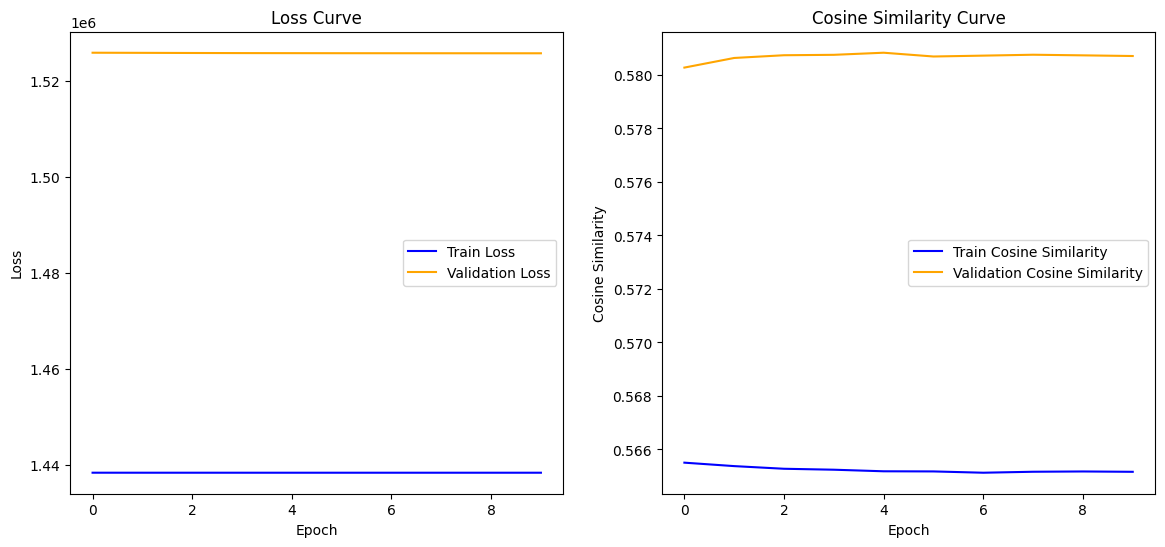

In [10]:
# Cell 7: Vẽ các đường cong Loss và Cosine Similarity

import matplotlib.pyplot as plt

# Vẽ Loss Curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Vẽ Cosine Similarity Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['cosine_similarity'], label='Train Cosine Similarity', color='blue')
plt.plot(history.history['val_cosine_similarity'], label='Validation Cosine Similarity', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Curve')
plt.legend()

plt.show()